In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Subset
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Reshape, Lambda, Conv2DTranspose, Activation, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

### Function to Visualize some images from the dataset

In [11]:
def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 10))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

### Function to Load and preprocess the Fashion MNIST dataset for all models

In [12]:
def load_preprocess_data():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test), (x_train.reshape((-1, 28*28)), y_train), (x_test.reshape((-1, 28*28)), y_test), y_train_cat, y_test_cat

### Function to Visualize the accuracies of different models

In [13]:
def plot_accuracies(models, accuracies):
    # Sort the models and accuracies by descending order of accuracy
    models_accuracies = sorted(zip(models, accuracies), key=lambda x: x[1], reverse=True)
    models_sorted, accuracies_sorted = zip(*models_accuracies)

    plt.figure(figsize=(12, 8))
    bars = plt.bar(models_sorted, accuracies_sorted, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'gray', 'lime', 'pink'])
    plt.title('Model Accuracies')
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)

    # Add accuracy values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

    plt.show()

### Data Preparation and Visualization

In [14]:
(x_train, y_train), (x_test, y_test), (x_train_flat, y_train_flat), (x_test_flat, y_test_flat), y_train_cat, y_test_cat = load_preprocess_data()

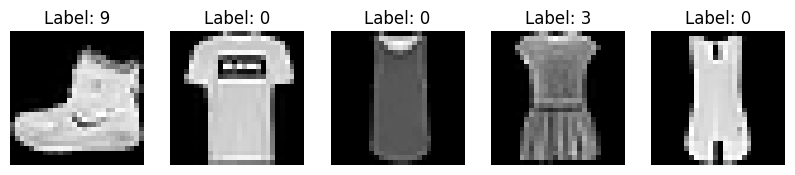

In [15]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
visualize_images(train_dataset)

### Image Classification Models

#### MLP Training

Epoch 1/10
300/300 - 12s - loss: 0.5010 - accuracy: 0.8235 - val_loss: 0.4483 - val_accuracy: 0.8376 - 12s/epoch - 41ms/step
Epoch 2/10
300/300 - 10s - loss: 0.3591 - accuracy: 0.8697 - val_loss: 0.3824 - val_accuracy: 0.8660 - 10s/epoch - 32ms/step
Epoch 3/10
300/300 - 9s - loss: 0.3229 - accuracy: 0.8814 - val_loss: 0.4090 - val_accuracy: 0.8544 - 9s/epoch - 31ms/step
Epoch 4/10
300/300 - 10s - loss: 0.2978 - accuracy: 0.8899 - val_loss: 0.3469 - val_accuracy: 0.8733 - 10s/epoch - 34ms/step
Epoch 5/10
300/300 - 5s - loss: 0.2783 - accuracy: 0.8960 - val_loss: 0.3402 - val_accuracy: 0.8772 - 5s/epoch - 16ms/step
Epoch 6/10
300/300 - 6s - loss: 0.2635 - accuracy: 0.9019 - val_loss: 0.3342 - val_accuracy: 0.8801 - 6s/epoch - 21ms/step
Epoch 7/10
300/300 - 5s - loss: 0.2494 - accuracy: 0.9076 - val_loss: 0.3129 - val_accuracy: 0.8867 - 5s/epoch - 17ms/step
Epoch 8/10
300/300 - 5s - loss: 0.2356 - accuracy: 0.9114 - val_loss: 0.3269 - val_accuracy: 0.8802 - 5s/epoch - 17ms/step
Epoch 9/10

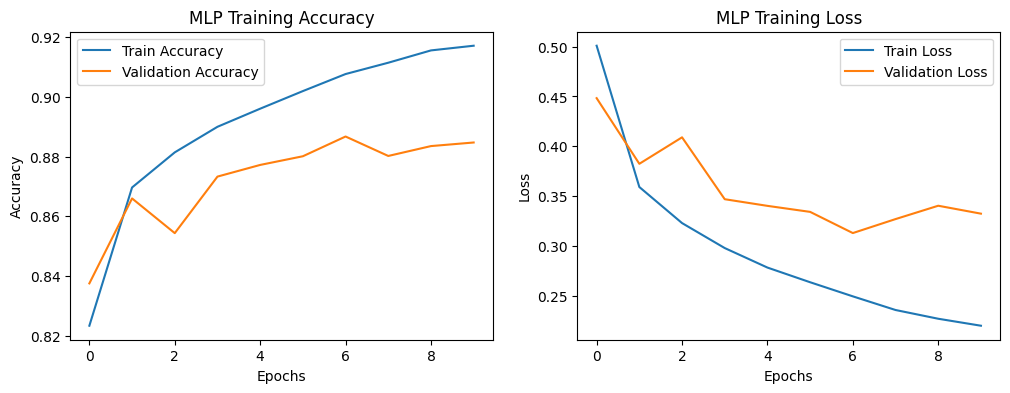

In [16]:
def train_mlp(x_train, y_train_cat, x_test, y_test_cat):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=200, verbose=2)
    scores = model.evaluate(x_test, y_test_cat, verbose=0)
    accuracy = scores[1] * 100
    print(f'MLP Accuracy: {accuracy}%')
    return history, accuracy

def plot_mlp_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('MLP Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('MLP Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Train MLP model
mlp_history, mlp_accuracy = train_mlp(x_train, y_train_cat, x_test, y_test_cat)
plot_mlp_history(mlp_history)

#### SVM Training

In [17]:
def train_svm(x_train_flat, y_train, x_test_flat, y_test):
    model = svm.SVC(kernel='linear')
    model.fit(x_train_flat, y_train)
    y_pred = model.predict(x_test_flat)
    accuracy = accuracy_score(y_test, y_pred) * 100
    print(f'SVM Accuracy: {accuracy}%')
    return accuracy

# Train SVM model
svm_accuracy = train_svm(x_train_flat, y_train, x_test_flat, y_test)

SVM Accuracy: 84.63000000000001%


#### KNN Training

In [18]:
def train_knn(x_train_flat, y_train, x_test_flat, y_test):
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(x_train_flat, y_train)
    y_pred = model.predict(x_test_flat)
    accuracy = accuracy_score(y_test, y_pred) * 100
    print(f'KNN Accuracy: {accuracy}%')
    return accuracy

# Train KNN model
knn_accuracy = train_knn(x_train_flat, y_train, x_test_flat, y_test)

KNN Accuracy: 85.41%


#### CNN Training

Epoch 1/10
300/300 - 47s - loss: 0.5953 - accuracy: 0.7896 - val_loss: 0.4182 - val_accuracy: 0.8526 - 47s/epoch - 157ms/step
Epoch 2/10
300/300 - 50s - loss: 0.3632 - accuracy: 0.8704 - val_loss: 0.3528 - val_accuracy: 0.8733 - 50s/epoch - 166ms/step
Epoch 3/10
300/300 - 47s - loss: 0.3154 - accuracy: 0.8876 - val_loss: 0.3248 - val_accuracy: 0.8841 - 47s/epoch - 155ms/step
Epoch 4/10
300/300 - 46s - loss: 0.2870 - accuracy: 0.8966 - val_loss: 0.3142 - val_accuracy: 0.8842 - 46s/epoch - 155ms/step
Epoch 5/10
300/300 - 49s - loss: 0.2656 - accuracy: 0.9041 - val_loss: 0.2923 - val_accuracy: 0.8955 - 49s/epoch - 164ms/step
Epoch 6/10
300/300 - 47s - loss: 0.2447 - accuracy: 0.9116 - val_loss: 0.2901 - val_accuracy: 0.8964 - 47s/epoch - 155ms/step
Epoch 7/10
300/300 - 46s - loss: 0.2308 - accuracy: 0.9153 - val_loss: 0.2695 - val_accuracy: 0.9027 - 46s/epoch - 154ms/step
Epoch 8/10
300/300 - 46s - loss: 0.2165 - accuracy: 0.9199 - val_loss: 0.2652 - val_accuracy: 0.9045 - 46s/epoch - 153

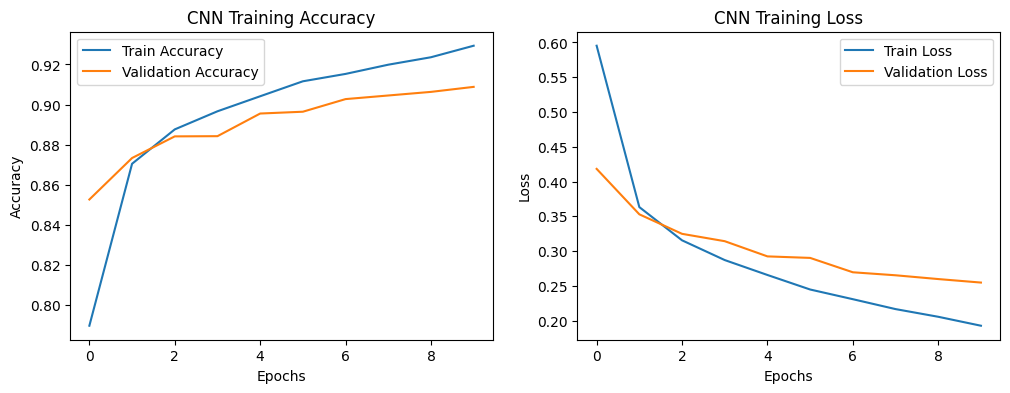

In [19]:
def train_cnn(x_train, y_train_cat, x_test, y_test_cat):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10, batch_size=200, verbose=2)
    scores = model.evaluate(x_test, y_test_cat, verbose=0)
    accuracy = scores[1] * 100
    print(f'CNN Accuracy: {accuracy}%')
    return history, accuracy

def plot_cnn_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Train CNN model
cnn_history, cnn_accuracy = train_cnn(x_train.reshape(-1, 28, 28, 1), y_train_cat, x_test.reshape(-1, 28, 28, 1), y_test_cat)
plot_cnn_history(cnn_history)

#### Random Forest Training

In [20]:
def train_random_forest(x_train_flat, y_train, x_test_flat, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(x_train_flat, y_train)
    y_pred = model.predict(x_test_flat)
    accuracy = accuracy_score(y_test, y_pred) * 100
    print(f'Random Forest Accuracy: {accuracy:.2f}%')
    return accuracy

# Train Random Forest model
random_forest_accuracy = train_random_forest(x_train_flat, y_train, x_test_flat, y_test)

Random Forest Accuracy: 87.64%


#### XGBoost Training

In [21]:
def train_xgboost(x_train_flat, y_train, x_test_flat, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(x_train_flat, y_train)
    y_pred = model.predict(x_test_flat)
    accuracy = accuracy_score(y_test, y_pred) * 100
    print(f'XGBoost Accuracy: {accuracy:.2f}%')
    return accuracy

# Train XGBoost model
xgboost_accuracy = train_xgboost(x_train_flat, y_train, x_test_flat, y_test)

XGBoost Accuracy: 89.85%


### Plotting Accuracies of the models

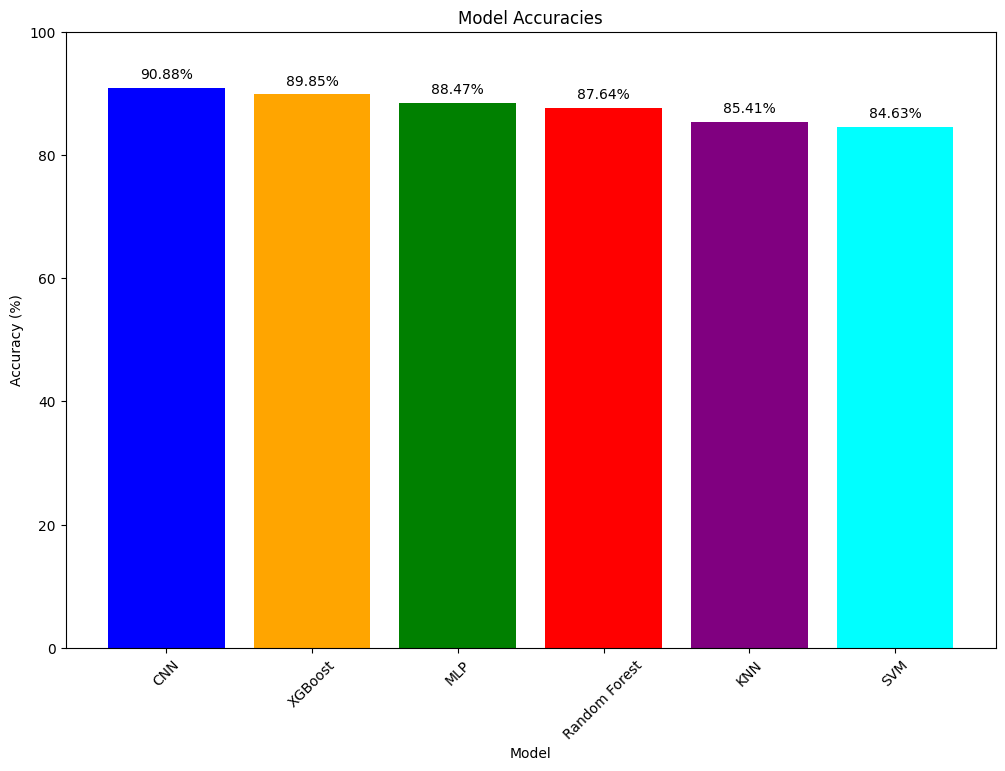

In [22]:
models = ['MLP', 'SVM', 'KNN', 'CNN', 'Random Forest', 'XGBoost']
accuracies = [mlp_accuracy, svm_accuracy, knn_accuracy, cnn_accuracy, random_forest_accuracy, xgboost_accuracy]
plot_accuracies(models, accuracies)